# Comprehensive E-commerce Machine Learning Models

This notebook contains four complete machine learning models for e-commerce data analysis:

1. **Product Recommendation** - Suggest products based on past behavior using collaborative filtering
2. **Order Amount Prediction** - Predict payment amount based on order details
3. **Customer Churn Prediction** - Predict if a customer will return for another purchase
4. **Return Prediction** - Predict if a product/order will be returned

Each section is self-contained with data loading, preprocessing, model training, and evaluation.

## Setup and Common Imports

First, let's import all the necessary libraries that will be used across the different models.

In [52]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pickle
import warnings
from datetime import datetime, timedelta

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    mean_squared_error, mean_absolute_error, r2_score
)

# Classification models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor

# Recommendation models
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(style="whitegrid")

# Suppress warnings
warnings.filterwarnings('ignore')

# Create output directory if it doesn't exist
os.makedirs('D:/ML/ecommerce_models', exist_ok=True)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Data Loading and Initial Exploration

Let's load the e-commerce dataset and explore its structure.

In [3]:
df = pd.read_excel('D:/ML/data.xlsx', nrows=5000)

Loading data...
Data loaded (SAMPLE): 50000 rows and 24 columns
Data loading completed in 10.48 seconds


In [4]:
# Display basic information about the dataset
print("\nDataset Information:")
print(f"Columns: {df.columns.tolist()}")
print("\nData Types:")
print(df.dtypes)
print("\nFirst 5 rows:")
df.head()


Dataset Information:
Columns: ['customer_id', 'first_name', 'last_name', 'order_id', 'order_date', 'order_status', 'order_detail_id', 'product_id', 'product_name', 'quantity', 'unit_price', 'total_line_price', 'discount_id', 'percentage', 'payment_id', 'payment_amount', 'payment_date', 'return_id', 'return_status', 'return_date', 'session_id', 'session_start', 'session_end', 'session_duration_minutes']

Data Types:
customer_id                          int64
first_name                          object
last_name                           object
order_id                             int64
order_date                  datetime64[ns]
order_status                        object
order_detail_id                      int64
product_id                           int64
product_name                        object
quantity                             int64
unit_price                         float64
total_line_price                   float64
discount_id                        float64
percentage           

,customer_id,first_name,last_name,order_id,order_date,order_status,order_detail_id,product_id,product_name,quantity,...,payment_id,payment_amount,payment_date,return_id,return_status,return_date,session_id,session_start,session_end,session_duration_minutes
0,13,Andrea,Miller,1,2025-04-05 09:06:50,shipped,1,38,Self-enabling leadingedge utilization,3,...,1.0,521.85,2025-04-05 10:06:50,NaN,NaN,NaT,83,2025-05-03 18:45:20,2025-05-03 20:04:20,79
1,13,Andrea,Miller,1,2025-04-05 09:06:50,shipped,1,38,Self-enabling leadingedge utilization,3,...,1.0,521.85,2025-04-05 10:06:50,NaN,NaN,NaT,84,2025-02-20 10:55:18,2025-02-20 12:23:18,88
2,13,Andrea,Miller,1,2025-04-05 09:06:50,shipped,1,38,Self-enabling leadingedge utilization,3,...,1.0,521.85,2025-04-05 10:06:50,NaN,NaN,NaT,85,2025-01-12 03:41:33,2025-01-12 04:04:33,23
3,13,Andrea,Miller,1,2025-04-05 09:06:50,shipped,1,38,Self-enabling leadingedge utilization,3,...,1.0,521.85,2025-04-05 10:06:50,NaN,NaN,NaT,86,2025-02-26 20:44:56,2025-02-26 22:18:56,94
4,13,Andrea,Miller,1,2025-04-05 09:06:50,shipped,1,38,Self-enabling leadingedge utilization,3,...,1.0,521.85,2025-04-05 10:06:50,NaN,NaN,NaT,87,2025-03-08 16:02:43,2025-03-08 17:37:43,95


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values:")
print(missing_values[missing_values > 0])

# Convert date columns to datetime
date_columns = ['order_date', 'payment_date', 'return_date', 'session_start', 'session_end']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])

# Basic statistics
print("\nBasic statistics for numerical columns:")
df.describe()


Missing values:
discount_id       47853
percentage        47853
payment_id         9739
payment_amount     9739
payment_date       9739
return_id         49755
return_status     49755
return_date       49755
dtype: int64

Basic statistics for numerical columns:


,customer_id,order_id,order_date,order_detail_id,product_id,quantity,unit_price,total_line_price,discount_id,percentage,payment_id,payment_amount,payment_date,return_id,return_date,session_id,session_start,session_end,session_duration_minutes
count,50000.000000,50000.000000,50000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,2147.000000,2147.000000,40261.000000,40261.000000,40261,245.000000,245,50000.000000,50000,50000,50000.000000
mean,133.728860,410.326640,2025-03-03 11:47:23.655379968,1239.078760,324.500040,2.950220,491.918850,1462.774659,34.639031,26.571085,331.728695,5427.952934,2025-03-02 03:28:50.300563968,3.253061,2025-03-06 10:05:17.302041088,3007.610880,2025-03-05 15:35:58.155620096,2025-03-05 16:38:06.477619968,62.138700
min,1.000000,1.000000,2025-01-01 09:16:58,1.000000,1.000000,1.000000,10.980000,11.410000,4.000000,8.300000,1.000000,35.010000,2025-01-01 10:16:58,1.000000,2025-02-13 06:09:43,1.000000,2025-01-01 01:18:41,2025-01-01 01:46:16,5.000000
25%,76.000000,288.000000,2025-01-29 14:51:04,834.000000,185.000000,2.000000,233.000000,526.120000,22.000000,18.150000,234.000000,3334.640000,2025-01-28 01:15:15,2.000000,2025-02-26 09:34:57,1327.000000,2025-02-02 04:33:15,2025-02-02 05:40:08.500000,32.000000
50%,131.000000,418.000000,2025-03-02 16:19:12,1259.000000,335.000000,3.000000,468.940000,1100.240000,37.000000,24.330000,337.000000,5042.900000,2025-02-28 00:27:16,3.000000,2025-02-26 09:34:57,2781.000000,2025-03-06 10:25:57,2025-03-06 10:35:57,63.000000
75%,194.000000,549.000000,2025-04-04 16:26:39,1691.000000,467.000000,4.000000,753.410000,2194.880000,49.000000,38.900000,443.000000,7481.520000,2025-04-02 04:28:13,4.000000,2025-03-23 03:09:13,4751.000000,2025-04-05 16:55:04.500000,2025-04-05 17:42:00,90.000000
max,250.000000,695.000000,2025-05-07 22:59:00,2131.000000,600.000000,5.000000,996.570000,4974.000000,60.000000,49.740000,557.000000,15450.340000,2025-05-07 23:59:00,5.000000,2025-03-31 12:51:11,6428.000000,2025-05-07 23:21:31,2025-05-08 01:05:31,120.000000
std,68.006864,169.887445,NaN,534.720656,166.526253,1.410171,287.205545,1168.641822,16.016785,13.251561,135.810115,2881.976620,NaN,1.318702,NaN,1933.238501,NaN,NaN,33.387143


## Common Data Preprocessing

Let's perform some common preprocessing steps that will be useful for all models.

In [6]:
def preprocess_common_data(df):
    """
    Perform common preprocessing steps on the dataset.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The raw dataset
        
    Returns:
    --------
    pandas.DataFrame
        The preprocessed dataset
    """
    print("Performing common preprocessing...")
    df_processed = df.copy()
    
    # Handle missing values in return_status (NaN means no return)
    df_processed['return_status_filled'] = df_processed['return_status'].fillna('not_returned')
    
    # Create binary target variable for returns (1 if returned, 0 if not)
    df_processed['is_returned'] = df_processed['return_status_filled'].apply(
        lambda x: 0 if x == 'not_returned' else 1
    )
    
    # Create time-based features
    df_processed['order_day_of_week'] = df_processed['order_date'].dt.dayofweek
    df_processed['order_hour'] = df_processed['order_date'].dt.hour
    df_processed['order_month'] = df_processed['order_date'].dt.month
    
    # Create session duration in minutes if not already present
    if 'session_duration_minutes' not in df_processed.columns and 'session_start' in df_processed.columns and 'session_end' in df_processed.columns:
        df_processed['session_duration_minutes'] = (df_processed['session_end'] - df_processed['session_start']).dt.total_seconds() / 60
    
    # Binary indicator for discount presence
    df_processed['has_discount'] = df_processed['discount_id'].notna().astype(int)
    
    # Fill missing discount percentages with 0
    if 'percentage' in df_processed.columns:
        df_processed['percentage'] = df_processed['percentage'].fillna(0)
    
    print(f"Common preprocessing completed. Dataset shape: {df_processed.shape}")
    return df_processed

In [7]:
# Apply common preprocessing
df_processed = preprocess_common_data(df)

# Display the first few rows of the preprocessed data
df_processed.head()

Performing common preprocessing...
Common preprocessing completed. Dataset shape: (50000, 30)


,customer_id,first_name,last_name,order_id,order_date,order_status,order_detail_id,product_id,product_name,quantity,...,session_id,session_start,session_end,session_duration_minutes,return_status_filled,is_returned,order_day_of_week,order_hour,order_month,has_discount
0,13,Andrea,Miller,1,2025-04-05 09:06:50,shipped,1,38,Self-enabling leadingedge utilization,3,...,83,2025-05-03 18:45:20,2025-05-03 20:04:20,79,not_returned,0,5,9,4,0
1,13,Andrea,Miller,1,2025-04-05 09:06:50,shipped,1,38,Self-enabling leadingedge utilization,3,...,84,2025-02-20 10:55:18,2025-02-20 12:23:18,88,not_returned,0,5,9,4,0
2,13,Andrea,Miller,1,2025-04-05 09:06:50,shipped,1,38,Self-enabling leadingedge utilization,3,...,85,2025-01-12 03:41:33,2025-01-12 04:04:33,23,not_returned,0,5,9,4,0
3,13,Andrea,Miller,1,2025-04-05 09:06:50,shipped,1,38,Self-enabling leadingedge utilization,3,...,86,2025-02-26 20:44:56,2025-02-26 22:18:56,94,not_returned,0,5,9,4,0
4,13,Andrea,Miller,1,2025-04-05 09:06:50,shipped,1,38,Self-enabling leadingedge utilization,3,...,87,2025-03-08 16:02:43,2025-03-08 17:37:43,95,not_returned,0,5,9,4,0


# 1. Product Recommendation System

In this section, we'll build a product recommendation system using collaborative filtering techniques.

## 1.1 Data Preparation for Recommendation System

In [8]:
def prepare_recommendation_data(df):
    """
    Prepare data for the recommendation system.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The preprocessed dataset
        
    Returns:
    --------
    tuple
        (user_product_matrix, product_df, user_mapping, product_mapping)
    """
    print("Preparing data for recommendation system...")
    
    # Create a user-product interaction matrix
    # We'll use the quantity as the interaction strength
    user_product_df = df.groupby(['customer_id', 'product_id'])['quantity'].sum().reset_index()
    print(f"Created user-product interaction matrix with {len(user_product_df)} interactions")
    
    # Create mappings for customer_id and product_id to matrix indices
    unique_users = user_product_df['customer_id'].unique()
    unique_products = user_product_df['product_id'].unique()
    
    user_mapping = {user: i for i, user in enumerate(unique_users)}
    product_mapping = {product: i for i, product in enumerate(unique_products)}
    
    # Create a sparse matrix for user-product interactions
    user_indices = user_product_df['customer_id'].map(user_mapping).values
    product_indices = user_product_df['product_id'].map(product_mapping).values
    quantities = user_product_df['quantity'].values
    
    user_product_matrix = csr_matrix((quantities, (user_indices, product_indices)), 
                                     shape=(len(unique_users), len(unique_products)))
    
    # Create a product dataframe with additional information
    product_df = df.groupby('product_id').agg({
        'product_name': 'first',
        'unit_price': 'mean',
        'is_returned': 'mean',
        'quantity': 'sum'
    }).reset_index()
    
    product_df.columns = ['product_id', 'product_name', 'avg_price', 'return_rate', 'total_quantity']
    
    print(f"Matrix shape: {user_product_matrix.shape} (users × products)")
    print(f"Number of unique users: {len(unique_users)}")
    print(f"Number of unique products: {len(unique_products)}")
    
    return user_product_matrix, product_df, user_mapping, product_mapping

In [9]:
# Prepare data for recommendation system
user_product_matrix, product_df, user_mapping, product_mapping = prepare_recommendation_data(df_processed)

# Display product information
print("\nProduct information:")
product_df.head()

Preparing data for recommendation system...
Created user-product interaction matrix with 2064 interactions
Matrix shape: (233, 577) (users × products)
Number of unique users: 233
Number of unique products: 577

Product information:


,product_id,product_name,avg_price,return_rate,total_quantity
0,1,Enterprise-wide stable synergy,605.06,0.0,82
1,2,Synergized uniform contingency,678.15,0.0,138
2,3,Function-based well-modulated intranet,712.42,0.0,57
3,4,Monitored bifurcated database,110.51,0.0,337
4,5,Versatile modular info-mediaries,285.49,0.0,235


## 1.2 Building the Recommendation Model using Matrix Factorization

In [10]:
def build_recommendation_model(user_product_matrix, n_components=50):
    """
    Build a recommendation model using matrix factorization.
    
    Parameters:
    -----------
    user_product_matrix : scipy.sparse.csr_matrix
        The user-product interaction matrix
    n_components : int
        Number of latent factors to use
        
    Returns:
    --------
    tuple
        (svd_model, user_factors, product_factors)
    """
    print(f"Building recommendation model with {n_components} latent factors...")
    start_time = time.time()
    
    # Apply Truncated SVD (matrix factorization)
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    user_factors = svd.fit_transform(user_product_matrix)
    product_factors = svd.components_.T
    
    # Calculate explained variance
    explained_variance = svd.explained_variance_ratio_.sum() * 100
    
    end_time = time.time()
    print(f"Model built in {end_time - start_time:.2f} seconds")
    print(f"Explained variance: {explained_variance:.2f}%")
    
    return svd, user_factors, product_factors

In [11]:
# Build the recommendation model
svd_model, user_factors, product_factors = build_recommendation_model(user_product_matrix, n_components=50)

Building recommendation model with 50 latent factors...
Model built in 0.03 seconds
Explained variance: 66.06%


## 1.3 Generating Product Recommendations

In [12]:
def get_product_recommendations(user_id, user_mapping, product_mapping, user_factors, product_factors, product_df, n_recommendations=5):
    """
    Get product recommendations for a specific user.
    
    Parameters:
    -----------
    user_id : int
        The user ID to get recommendations for
    user_mapping : dict
        Mapping from user IDs to matrix indices
    product_mapping : dict
        Mapping from product IDs to matrix indices
    user_factors : numpy.ndarray
        User latent factors
    product_factors : numpy.ndarray
        Product latent factors
    product_df : pandas.DataFrame
        Product information dataframe
    n_recommendations : int
        Number of recommendations to return
        
    Returns:
    --------
    pandas.DataFrame
        Recommended products with scores
    """
    # Check if user exists in the mapping
    if user_id not in user_mapping:
        print(f"User ID {user_id} not found in the dataset.")
        return None
    
    # Get user index
    user_idx = user_mapping[user_id]
    
    # Get user's latent factors
    user_vector = user_factors[user_idx].reshape(1, -1)
    
    # Calculate similarity scores with all products
    scores = user_vector.dot(product_factors.T).flatten()
    
    # Create a mapping from matrix indices back to product IDs
    reverse_product_mapping = {v: k for k, v in product_mapping.items()}
    
    # Get top N product indices
    top_indices = scores.argsort()[::-1][:n_recommendations]
    
    # Convert indices to product IDs
    recommended_product_ids = [reverse_product_mapping[idx] for idx in top_indices]
    
    # Get product information
    recommendations = product_df[product_df['product_id'].isin(recommended_product_ids)].copy()
    
    # Add recommendation scores
    recommendations['recommendation_score'] = [scores[idx] for idx in top_indices]
    
    # Sort by recommendation score
    recommendations = recommendations.sort_values('recommendation_score', ascending=False)
    
    return recommendations

def get_similar_products(product_id, product_mapping, product_factors, product_df, n_recommendations=5):
    """
    Get similar products to a specific product.
    
    Parameters:
    -----------
    product_id : int
        The product ID to find similar products for
    product_mapping : dict
        Mapping from product IDs to matrix indices
    product_factors : numpy.ndarray
        Product latent factors
    product_df : pandas.DataFrame
        Product information dataframe
    n_recommendations : int
        Number of similar products to return
        
    Returns:
    --------
    pandas.DataFrame
        Similar products with similarity scores
    """
    # Check if product exists in the mapping
    if product_id not in product_mapping:
        print(f"Product ID {product_id} not found in the dataset.")
        return None
    
    # Get product index
    product_idx = product_mapping[product_id]
    
    # Get product's latent factors
    product_vector = product_factors[product_idx].reshape(1, -1)
    
    # Calculate similarity scores with all products
    similarities = cosine_similarity(product_vector, product_factors).flatten()
    
    # Create a mapping from matrix indices back to product IDs
    reverse_product_mapping = {v: k for k, v in product_mapping.items()}
    
    # Get top N+1 product indices (including the product itself)
    top_indices = similarities.argsort()[::-1][:n_recommendations+1]
    
    # Remove the product itself
    top_indices = [idx for idx in top_indices if idx != product_idx]
    
    # Convert indices to product IDs
    similar_product_ids = [reverse_product_mapping[idx] for idx in top_indices[:n_recommendations]]
    
    # Get product information
    similar_products = product_df[product_df['product_id'].isin(similar_product_ids)].copy()
    
    # Add similarity scores
    similar_products['similarity_score'] = [similarities[idx] for idx in top_indices[:n_recommendations]]
    
    # Sort by similarity score
    similar_products = similar_products.sort_values('similarity_score', ascending=False)
    
    return similar_products

In [13]:
# Get a sample user ID
sample_user_id = list(user_mapping.keys())[0]

# Get recommendations for the sample user
recommendations = get_product_recommendations(
    sample_user_id, user_mapping, product_mapping, 
    user_factors, product_factors, product_df, n_recommendations=5
)

print(f"\nRecommendations for user {sample_user_id}:")
recommendations


Recommendations for user 1:


,product_id,product_name,avg_price,return_rate,total_quantity,recommendation_score
3,4,Monitored bifurcated database,110.51,0.0,337,2.531330
27,28,Digitized zero administration help-desk,862.11,0.0,311,2.196243
37,38,Self-enabling leadingedge utilization,173.95,0.0,296,1.796904
63,64,Optimized content-based help-desk,392.29,0.0,321,1.600019
91,93,Proactive non-volatile standardization,942.01,0.0,220,1.481991


In [14]:
# Get a sample product ID
sample_product_id = list(product_mapping.keys())[0]

# Get similar products
similar_products = get_similar_products(
    sample_product_id, product_mapping, 
    product_factors, product_df, n_recommendations=5
)

# Get the name of the sample product
sample_product_name = product_df[product_df['product_id'] == sample_product_id]['product_name'].values[0]

print(f"\nProducts similar to {sample_product_name} (ID: {sample_product_id}):")
similar_products


Products similar to Enterprise-wide stable synergy (ID: 1):


,product_id,product_name,avg_price,return_rate,total_quantity,similarity_score
21,22,Vision-oriented solution-oriented hub,147.80,0.000000,110,0.999787
44,45,Balanced content-based conglomeration,351.39,0.123077,189,0.999431
51,52,Front-line bifurcated approach,312.21,0.000000,149,0.999233
92,94,Assimilated bi-directional Internet solution,248.48,0.000000,234,0.998971
94,96,Quality-focused static utilization,955.06,0.000000,198,0.998959


## 1.4 Saving the Recommendation Model

In [15]:
# Save the recommendation model components
recommendation_model_path = 'D:/ML/ecommerce_models/recommendation_model.pkl'

# Create a dictionary with all model components
recommendation_model = {
    'svd_model': svd_model,
    'user_factors': user_factors,
    'product_factors': product_factors,
    'user_mapping': user_mapping,
    'product_mapping': product_mapping,
    'product_df': product_df
}

# Save the model
with open(recommendation_model_path, 'wb') as f:
    pickle.dump(recommendation_model, f)

print(f"Recommendation model saved to {recommendation_model_path}")

Recommendation model saved to D:/ML/ecommerce_models/recommendation_model.pkl


## 1.6 Visualizing Model Performance

Visualize explained variance for the SVD model.

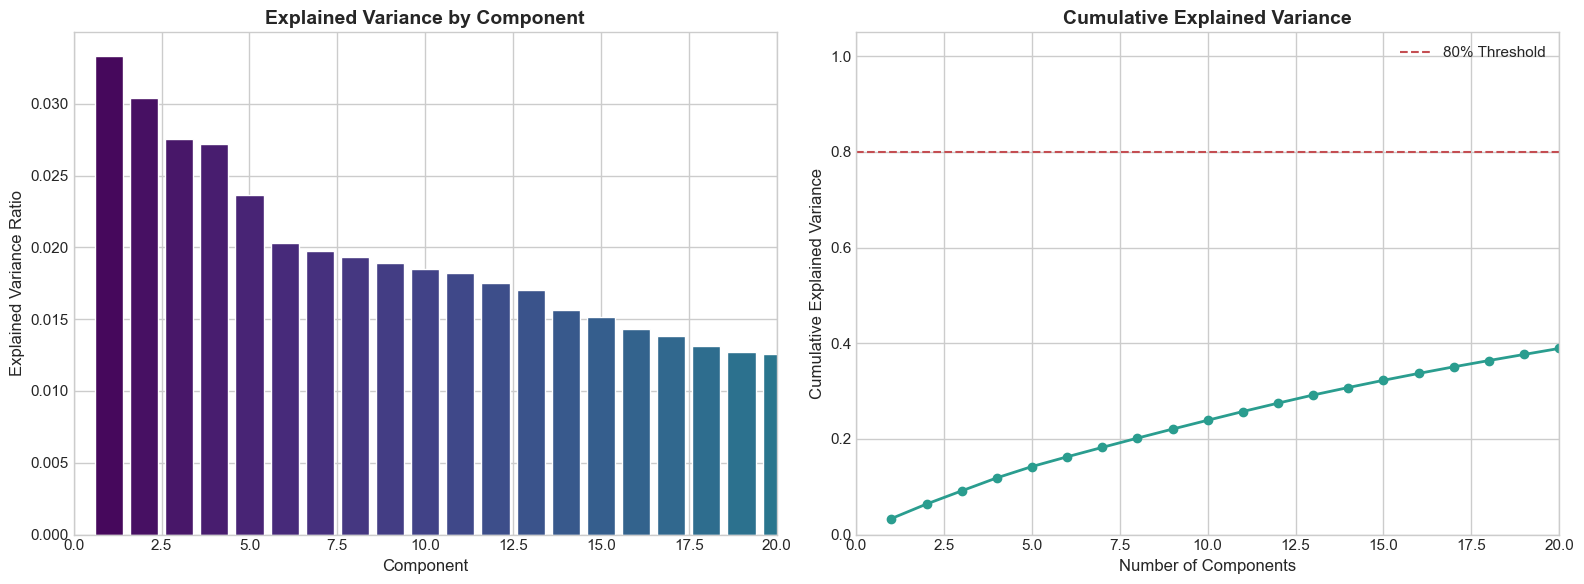

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Extract explained variance
explained_variance = svd_model.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot explained variance by component
components = range(1, len(explained_variance) + 1)
axes[0].bar(components, explained_variance, color=sns.color_palette("viridis", len(explained_variance)))
axes[0].set_title('Explained Variance by Component', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_xlim([0, min(20, len(explained_variance))])  # Show first 20 components

# Plot cumulative explained variance
axes[1].plot(components, cumulative_variance, marker='o', linestyle='-', color='#2a9d8f', linewidth=2)
axes[1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_xlim([0, min(20, len(explained_variance))])  # Show first 20 components
axes[1].set_ylim([0, 1.05])
axes[1].axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
axes[1].legend()

plt.tight_layout()
plt.show()

## 1.5 Example: How to Use the Recommendation Model

In [72]:
recommendations = recommend_products_for_user(
    123, 'D:/ML/ecommerce_models/recommendation_model.pkl'
)
print(recommendations)


     product_id                             product_name  avg_price  \
164         168       Decentralized grid-enabled toolset     535.24   
195         200       User-friendly user-facing firmware     105.75   
239         248           Compatible uniform application     467.11   
389         401             Automated tangible framework     524.93   
433         448  Automated contextually-based encryption     882.03   

     return_rate  total_quantity  recommendation_score  
164          0.0             431             17.107746  
195          0.0             822             13.879646  
239          0.0             381             12.759029  
389          0.0             287             12.201959  
433          0.0             525             12.135223  


# 2. Order Amount Prediction

In this section, we'll build a regression model to predict the payment amount based on order details.

## 2.1 Data Preparation for Order Amount Prediction

In [18]:
def prepare_order_amount_data(df):
    """
    Prepare data for order amount prediction.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The preprocessed dataset
        
    Returns:
    --------
    pandas.DataFrame
        Dataset prepared for order amount prediction
    """
    print("Preparing data for order amount prediction...")
    
    # Select relevant columns
    order_amount_df = df[[
        'customer_id', 'product_id', 'order_id', 'quantity', 'unit_price',
        'total_line_price', 'has_discount', 'percentage', 'payment_amount',
        'order_day_of_week', 'order_hour', 'order_month', 'session_duration_minutes'
    ]].copy()
    
    # Handle missing values
    order_amount_df['percentage'] = order_amount_df['percentage'].fillna(0)
    order_amount_df['session_duration_minutes'] = order_amount_df['session_duration_minutes'].fillna(
        order_amount_df['session_duration_minutes'].median()
    )
    
    # Drop rows with missing payment_amount
    rows_before = len(order_amount_df)
    order_amount_df = order_amount_df.dropna(subset=['payment_amount'])
    rows_after = len(order_amount_df)
    print(f"Dropped {rows_before - rows_after} rows with missing payment_amount")
    
    # Create additional features
    # Average payment amount per customer
    customer_avg_payment = order_amount_df.groupby('customer_id')['payment_amount'].mean().reset_index()
    customer_avg_payment.columns = ['customer_id', 'customer_avg_payment']
    order_amount_df = pd.merge(order_amount_df, customer_avg_payment, on='customer_id', how='left')
    
    # Average unit price per product
    product_avg_price = order_amount_df.groupby('product_id')['unit_price'].mean().reset_index()
    product_avg_price.columns = ['product_id', 'product_avg_price']
    order_amount_df = pd.merge(order_amount_df, product_avg_price, on='product_id', how='left')
    
    # Price deviation from average
    order_amount_df['price_deviation'] = order_amount_df['unit_price'] / order_amount_df['product_avg_price'] - 1
    
    # Fill any remaining missing values
    order_amount_df = order_amount_df.fillna(0)
    
    print(f"Data prepared for order amount prediction. Shape: {order_amount_df.shape}")
    return order_amount_df

In [19]:
# Prepare data for order amount prediction
order_amount_df = prepare_order_amount_data(df_processed)

# Display the first few rows
order_amount_df.head()

Preparing data for order amount prediction...
Dropped 9739 rows with missing payment_amount
Data prepared for order amount prediction. Shape: (40261, 16)


,customer_id,product_id,order_id,quantity,unit_price,total_line_price,has_discount,percentage,payment_amount,order_day_of_week,order_hour,order_month,session_duration_minutes,customer_avg_payment,product_avg_price,price_deviation
0,13,38,1,3,173.95,521.85,0,0.0,521.85,5,9,4,79,6165.820909,173.95,0.0
1,13,38,1,3,173.95,521.85,0,0.0,521.85,5,9,4,88,6165.820909,173.95,0.0
2,13,38,1,3,173.95,521.85,0,0.0,521.85,5,9,4,23,6165.820909,173.95,0.0
3,13,38,1,3,173.95,521.85,0,0.0,521.85,5,9,4,94,6165.820909,173.95,0.0
4,13,38,1,3,173.95,521.85,0,0.0,521.85,5,9,4,95,6165.820909,173.95,0.0


## 2.2 Feature Selection and Data Splitting

In [20]:
def prepare_order_amount_features(df):
    """
    Prepare features for order amount prediction.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The prepared dataset
        
    Returns:
    --------
    tuple
        (X_train, X_test, y_train, y_test, feature_names)
    """
    print("Preparing features for order amount prediction...")
    
    # Select features and target
    X = df.drop(['customer_id', 'product_id', 'order_id', 'payment_amount'], axis=1)
    y = df['payment_amount']
    
    # Get feature names
    feature_names = X.columns.tolist()
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    
    return X_train, X_test, y_train, y_test, feature_names

In [21]:
# Prepare features for order amount prediction
X_train_amount, X_test_amount, y_train_amount, y_test_amount, feature_names_amount = prepare_order_amount_features(order_amount_df)

# Display feature names
print("\nFeatures for order amount prediction:")
print(feature_names_amount)

Preparing features for order amount prediction...
Training set: 32208 samples
Testing set: 8053 samples

Features for order amount prediction:
['quantity', 'unit_price', 'total_line_price', 'has_discount', 'percentage', 'order_day_of_week', 'order_hour', 'order_month', 'session_duration_minutes', 'customer_avg_payment', 'product_avg_price', 'price_deviation']


## 2.3 Building and Evaluating Regression Models

In [22]:
def build_regression_models(X_train, y_train, X_test, y_test, feature_names):
    """
    Build and evaluate regression models for order amount prediction.
    
    Parameters:
    -----------
    X_train, X_test : pandas.DataFrame
        Training and testing features
    y_train, y_test : pandas.Series
        Training and testing targets
    feature_names : list
        Names of the features
        
    Returns:
    --------
    tuple
        (best_model, best_model_name, evaluation_results)
    """
    print("Building regression models for order amount prediction...")
    
    # Define preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), feature_names)]
    )
    
    # Define models to try
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'XGBoost': XGBRegressor(random_state=42, n_jobs=-1)
    }
    
    best_model = None
    best_r2 = -float('inf')
    best_model_name = None
    evaluation_results = []
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")
        start_time = time.time()
        
        # Create pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Predict
        y_pred = pipeline.predict(X_test)
        
        # Evaluate
        train_time = time.time() - start_time
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"{name} RMSE: {rmse:.2f}")
        print(f"{name} MAE: {mae:.2f}")
        print(f"{name} R²: {r2:.4f}")
        print(f"{name} Training time: {train_time:.2f} seconds")
        
        # Store results
        result = {
            'model_name': name,
            'model': pipeline,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'training_time': train_time,
            'y_pred': y_pred
        }
        evaluation_results.append(result)
        
        # Save best model
        if r2 > best_r2:
            best_r2 = r2
            best_model = pipeline
            best_model_name = name
    
    print(f"\nBest model: {best_model_name} with R²: {best_r2:.4f}")
    
    return best_model, best_model_name, evaluation_results

In [23]:
# Build and evaluate regression models
best_model_amount, best_model_name_amount, evaluation_results_amount = build_regression_models(
    X_train_amount, y_train_amount, X_test_amount, y_test_amount, feature_names_amount
)

Building regression models for order amount prediction...

Training Linear Regression...
Linear Regression RMSE: 2023.06
Linear Regression MAE: 1560.63
Linear Regression R²: 0.5024
Linear Regression Training time: 0.06 seconds

Training Ridge Regression...
Ridge Regression RMSE: 2023.06
Ridge Regression MAE: 1560.64
Ridge Regression R²: 0.5024
Ridge Regression Training time: 0.15 seconds

Training Random Forest...
Random Forest RMSE: 61.31
Random Forest MAE: 5.42
Random Forest R²: 0.9995
Random Forest Training time: 1.18 seconds

Training XGBoost...
XGBoost RMSE: 289.36
XGBoost MAE: 174.01
XGBoost R²: 0.9898
XGBoost Training time: 0.29 seconds

Best model: Random Forest with R²: 0.9995


## 2.4 Visualizing Model Performance

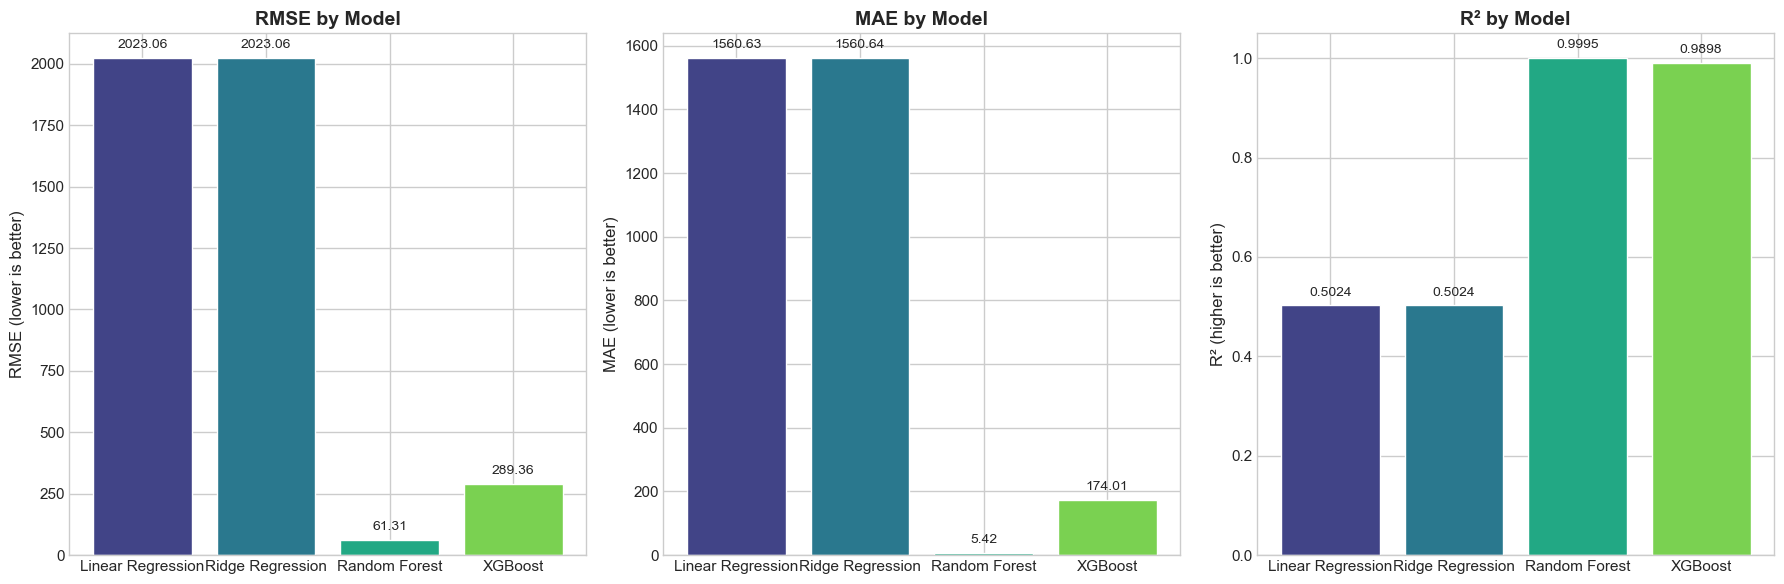

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Extract metrics
models = [result['model_name'] for result in evaluation_results_amount]
rmse = [result['rmse'] for result in evaluation_results_amount]
mae = [result['mae'] for result in evaluation_results_amount]
r2 = [result['r2'] for result in evaluation_results_amount]

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot RMSE
axes[0].bar(models, rmse, color=sns.color_palette("viridis", len(models)))
axes[0].set_title('RMSE by Model', fontsize=14, fontweight='bold')
axes[0].set_ylabel('RMSE (lower is better)', fontsize=12)
axes[0].set_ylim(bottom=0)

# Plot MAE
axes[1].bar(models, mae, color=sns.color_palette("viridis", len(models)))
axes[1].set_title('MAE by Model', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MAE (lower is better)', fontsize=12)
axes[1].set_ylim(bottom=0)

# Plot R²
axes[2].bar(models, r2, color=sns.color_palette("viridis", len(models)))
axes[2].set_title('R² by Model', fontsize=14, fontweight='bold')
axes[2].set_ylabel('R² (higher is better)', fontsize=12)
axes[2].set_ylim([0, 1.05])

# Add value labels on top of bars
for i, ax in enumerate(axes):
    values = [rmse, mae, r2][i]
    for j, v in enumerate(values):
        if i == 2:  # R² values
            ax.text(j, v + 0.02, f'{v:.4f}', ha='center', fontsize=10)
        else:  # RMSE and MAE values
            ax.text(j, v + (max(values) * 0.02), f'{v:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 2.5 Feature Importance Analysis

In [25]:
def analyze_feature_importance(model, model_name, feature_names):
    """
    Analyze feature importance for the regression model.
    
    Parameters:
    -----------
    model : sklearn.pipeline.Pipeline
        The trained model
    model_name : str
        Name of the model
    feature_names : list
        Names of the features
        
    Returns:
    --------
    dict or None
        Feature importance dictionary if available, None otherwise
    """
    feature_importance = {}
    
    if model_name in ['Random Forest', 'XGBoost']:
        if hasattr(model['regressor'], 'feature_importances_'):
            importances = model['regressor'].feature_importances_
            indices = np.argsort(importances)[::-1]
            
            print(f"\nFeature importance for {model_name}:")
            for i in range(min(10, len(feature_names))):
                feature_name = feature_names[indices[i]]
                importance = importances[indices[i]]
                print(f"{i+1}. {feature_name}: {importance:.4f}")
                feature_importance[feature_name] = importance
            
            # Visualize feature importance
            plt.figure(figsize=(12, 8))
            importance_df = pd.DataFrame({
                'Feature': [feature_names[i] for i in indices[:10]],
                'Importance': importances[indices[:10]]
            })
            sns.barplot(x='Importance', y='Feature', data=importance_df)
            plt.title(f'Top 10 Feature Importance - {model_name}')
            plt.tight_layout()
            plt.show()
            
            return feature_importance
    elif model_name in ['Linear Regression', 'Ridge Regression']:
        if hasattr(model['regressor'], 'coef_'):
            coefficients = model['regressor'].coef_
            # Get absolute coefficients
            abs_coefficients = np.abs(coefficients)
            indices = np.argsort(abs_coefficients)[::-1]
            
            print(f"\nFeature coefficients for {model_name}:")
            for i in range(min(10, len(feature_names))):
                feature_name = feature_names[indices[i]]
                coefficient = coefficients[indices[i]]
                print(f"{i+1}. {feature_name}: {coefficient:.4f}")
                feature_importance[feature_name] = abs_coefficients[indices[i]]
            
            # Visualize coefficients
            plt.figure(figsize=(12, 8))
            coef_df = pd.DataFrame({
                'Feature': [feature_names[i] for i in indices[:10]],
                'Coefficient': coefficients[indices[:10]]
            })
            sns.barplot(x='Coefficient', y='Feature', data=coef_df)
            plt.title(f'Top 10 Feature Coefficients - {model_name}')
            plt.tight_layout()
            plt.show()
            
            return feature_importance
    
    return None


Feature importance for Random Forest:
1. customer_avg_payment: 0.5187
2. total_line_price: 0.1627
3. order_hour: 0.1191
4. order_day_of_week: 0.0707
5. order_month: 0.0471
6. product_avg_price: 0.0289
7. unit_price: 0.0270
8. quantity: 0.0110
9. price_deviation: 0.0093
10. percentage: 0.0039


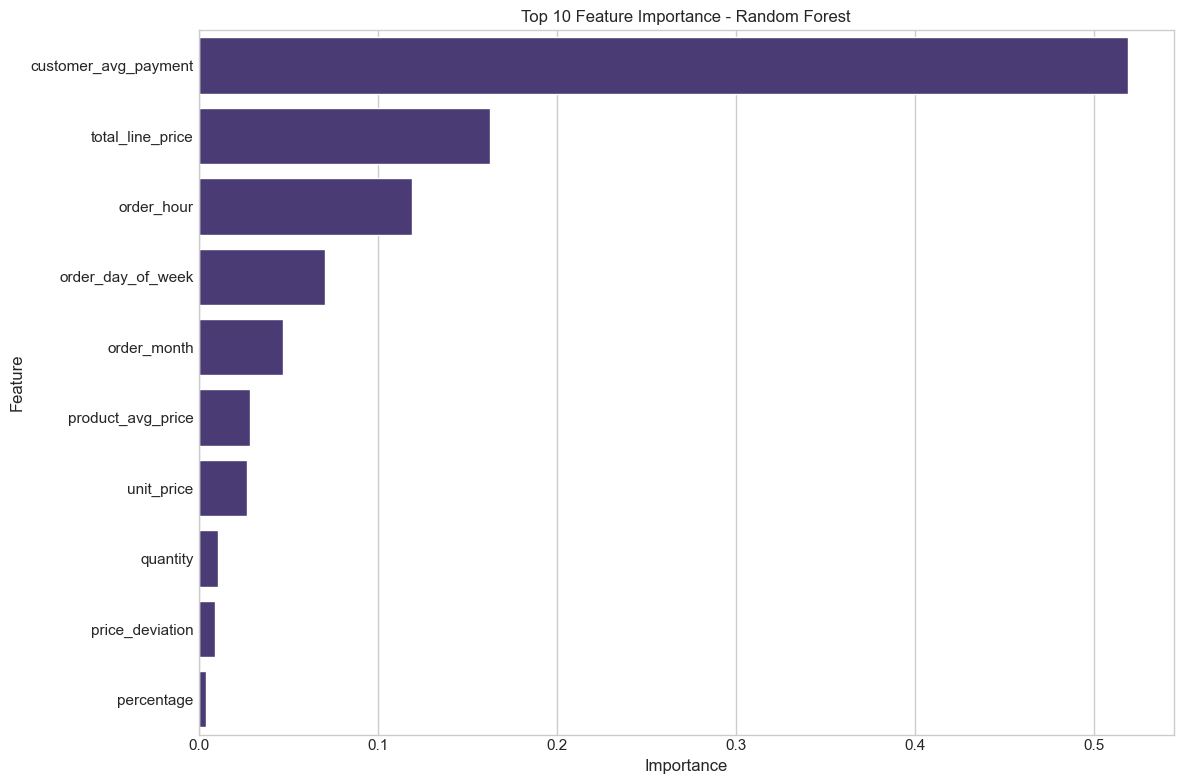

In [26]:
# Analyze feature importance for the best model
feature_importance_amount = analyze_feature_importance(
    best_model_amount, best_model_name_amount, feature_names_amount
)

## 2.6 Saving the Order Amount Prediction Model

In [49]:
import pickle  # Ensure pickle is imported
import os      # Optional: to check or create the directory if needed

# Define the path where the model will be saved
order_amount_model_path = 'D:/ML/ecommerce_models/order_amount_model.pkl'

# Ensure the directory exists
os.makedirs(os.path.dirname(order_amount_model_path), exist_ok=True)

#


## 2.7 Example: How to Use the Order Amount Prediction Model

In [62]:
new_order = {
    'quantity': 2,
    'unit_price': 150.0,
    'total_line_price': 300.0,
    'has_discount': 1,
    'percentage': 10.0,
    'order_day_of_week': 3,
    'order_hour': 14,
    'order_month': 5,
    'session_duration_minutes': 20.0,
    'customer_avg_payment': 250.0,
    'product_avg_price': 145.0,
    'price_deviation': 0.03
    }
#Run the function 
predict_order_amount(new_order,'D:/ML/ecommerce_models/order_amount_model.pkl')

493.80879999999985

# 3. Customer Churn Prediction

In this section, we'll build a classification model to predict if a customer will return for another purchase.

## 3.1 Data Preparation for Customer Churn Prediction

In [29]:
def prepare_customer_churn_data(df):
    """
    Prepare data for customer churn prediction.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The preprocessed dataset
        
    Returns:
    --------
    pandas.DataFrame
        Dataset prepared for customer churn prediction
    """
    print("Preparing data for customer churn prediction...")
    
    # Group by customer_id to get customer-level features
    customer_df = df.groupby('customer_id').agg({
        'order_id': 'nunique',                      # Number of orders
        'product_id': 'nunique',                    # Number of unique products
        'payment_amount': ['mean', 'sum', 'count'], # Payment statistics
        'is_returned': 'mean',                      # Return rate
        'session_duration_minutes': 'mean',         # Average session duration
        'has_discount': 'mean',                     # Discount usage rate
        'order_date': ['min', 'max']                # First and last order dates
    }).reset_index()
    
    # Flatten multi-level column names
    customer_df.columns = [
        'customer_id', 'order_count', 'product_count', 
        'avg_payment', 'total_payment', 'transaction_count',
        'return_rate', 'avg_session_duration', 'discount_rate',
        'first_order_date', 'last_order_date'
    ]
    
    # Calculate days since last order
    reference_date = pd.to_datetime('2025-05-31')
    customer_df['days_since_last_order'] = (reference_date - customer_df['last_order_date']).dt.days
    
    # Calculate customer lifetime (days between first and last order)
    customer_df['customer_lifetime_days'] = (customer_df['last_order_date'] - customer_df['first_order_date']).dt.days
    
    # Calculate average time between orders
    customer_df['avg_days_between_orders'] = customer_df['customer_lifetime_days'] / customer_df['order_count']
    customer_df['avg_days_between_orders'] = customer_df['avg_days_between_orders'].replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Define churn based on days since last order
    # If a customer hasn't ordered in 90 days, consider them churned
    churn_threshold = 90
    customer_df['is_churned'] = (customer_df['days_since_last_order'] > churn_threshold).astype(int)
    
    # Drop date columns as they're not useful for modeling
    customer_df = customer_df.drop(['first_order_date', 'last_order_date'], axis=1)
    
    # Handle any remaining missing values
    customer_df = customer_df.fillna(0)
    
    print(f"Data prepared for customer churn prediction. Shape: {customer_df.shape}")
    print(f"Churn rate: {customer_df['is_churned'].mean() * 100:.2f}%")
    
    return customer_df

In [30]:
# Prepare data for customer churn prediction
customer_churn_df = prepare_customer_churn_data(df_processed)

# Display the first few rows
customer_churn_df.head()

Preparing data for customer churn prediction...
Data prepared for customer churn prediction. Shape: (233, 13)
Churn rate: 18.03%


,customer_id,order_count,product_count,avg_payment,total_payment,transaction_count,return_rate,avg_session_duration,discount_rate,days_since_last_order,customer_lifetime_days,avg_days_between_orders,is_churned
0,1,3,8,4794.200000,258886.80,54,0.0,53.166667,0.111111,37,88,29.333333,0
1,2,2,3,2792.450000,19547.15,7,0.0,55.285714,0.000000,66,76,38.000000,0
2,3,6,13,3772.653636,41499.19,11,0.0,91.000000,0.000000,43,86,14.333333,0
3,4,4,14,6350.959375,1016153.50,160,0.0,63.100000,0.062500,67,40,10.000000,0
4,5,6,19,6016.539412,306843.51,51,0.0,75.666667,0.000000,25,106,17.666667,0


## 3.2 Feature Selection and Data Splitting

In [31]:
def prepare_churn_features(df):
    """
    Prepare features for customer churn prediction.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The prepared dataset
        
    Returns:
    --------
    tuple
        (X_train, X_test, y_train, y_test, feature_names)
    """
    print("Preparing features for customer churn prediction...")
    
    # Select features and target
    X = df.drop(['customer_id', 'is_churned'], axis=1)
    y = df['is_churned']
    
    # Get feature names
    feature_names = X.columns.tolist()
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    print(f"Churn rate in training set: {y_train.mean() * 100:.2f}%")
    print(f"Churn rate in testing set: {y_test.mean() * 100:.2f}%")
    
    return X_train, X_test, y_train, y_test, feature_names

In [32]:
# Prepare features for customer churn prediction
X_train_churn, X_test_churn, y_train_churn, y_test_churn, feature_names_churn = prepare_churn_features(customer_churn_df)

# Display feature names
print("\nFeatures for customer churn prediction:")
print(feature_names_churn)

Preparing features for customer churn prediction...
Training set: 186 samples
Testing set: 47 samples
Churn rate in training set: 18.28%
Churn rate in testing set: 17.02%

Features for customer churn prediction:
['order_count', 'product_count', 'avg_payment', 'total_payment', 'transaction_count', 'return_rate', 'avg_session_duration', 'discount_rate', 'days_since_last_order', 'customer_lifetime_days', 'avg_days_between_orders']


## 3.3 Building and Evaluating Classification Models

In [33]:
def build_classification_models(X_train, y_train, X_test, y_test, feature_names):
    """
    Build and evaluate classification models for customer churn prediction.
    
    Parameters:
    -----------
    X_train, X_test : pandas.DataFrame
        Training and testing features
    y_train, y_test : pandas.Series
        Training and testing targets
    feature_names : list
        Names of the features
        
    Returns:
    --------
    tuple
        (best_model, best_model_name, evaluation_results)
    """
    print("Building classification models for customer churn prediction...")
    
    # Define preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), feature_names)]
    )
    
    # Define models to try
    models = {
        'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1),
        'XGBoost': XGBClassifier(scale_pos_weight=len(y_train)/sum(y_train), random_state=42, n_jobs=-1)
    }
    
    best_model = None
    best_auc = 0
    best_model_name = None
    evaluation_results = []
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")
        start_time = time.time()
        
        # Create pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Predict
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:,1]
        
        # Evaluate
        train_time = time.time() - start_time
        auc = roc_auc_score(y_test, y_pred_proba)
        
        # Get classification report as dictionary
        report = classification_report(y_test, y_pred, output_dict=True)
        
        # Get confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        print(f"{name} AUC-ROC: {auc:.4f}")
        print(f"{name} Training time: {train_time:.2f} seconds")
        print(f"{name} Classification Report:")
        print(classification_report(y_test, y_pred))
        print(f"{name} Confusion Matrix:")
        print(cm)
        
        # Store results
        result = {
            'model_name': name,
            'model': pipeline,
            'auc': auc,
            'training_time': train_time,
            'precision': report['1']['precision'],
            'recall': report['1']['recall'],
            'f1_score': report['1']['f1-score'],
            'confusion_matrix': cm,
            'y_pred_proba': y_pred_proba
        }
        evaluation_results.append(result)
        
        # Save best model
        if auc > best_auc:
            best_auc = auc
            best_model = pipeline
            best_model_name = name
    
    print(f"\nBest model: {best_model_name} with AUC-ROC: {best_auc:.4f}")
    
    return best_model, best_model_name, evaluation_results

In [34]:
# Build and evaluate classification models
best_model_churn, best_model_name_churn, evaluation_results_churn = build_classification_models(
    X_train_churn, y_train_churn, X_test_churn, y_test_churn, feature_names_churn
)

Building classification models for customer churn prediction...

Training Logistic Regression...
Logistic Regression AUC-ROC: 1.0000
Logistic Regression Training time: 0.01 seconds
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        39
           1       0.67      1.00      0.80         8

    accuracy                           0.91        47
   macro avg       0.83      0.95      0.87        47
weighted avg       0.94      0.91      0.92        47

Logistic Regression Confusion Matrix:
[[35  4]
 [ 0  8]]

Training Random Forest...
Random Forest AUC-ROC: 1.0000
Random Forest Training time: 0.25 seconds
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00         8

    accuracy                           1.00        47
   macro avg       1.00      1.00     

## 3.4 Visualizing Model Performance

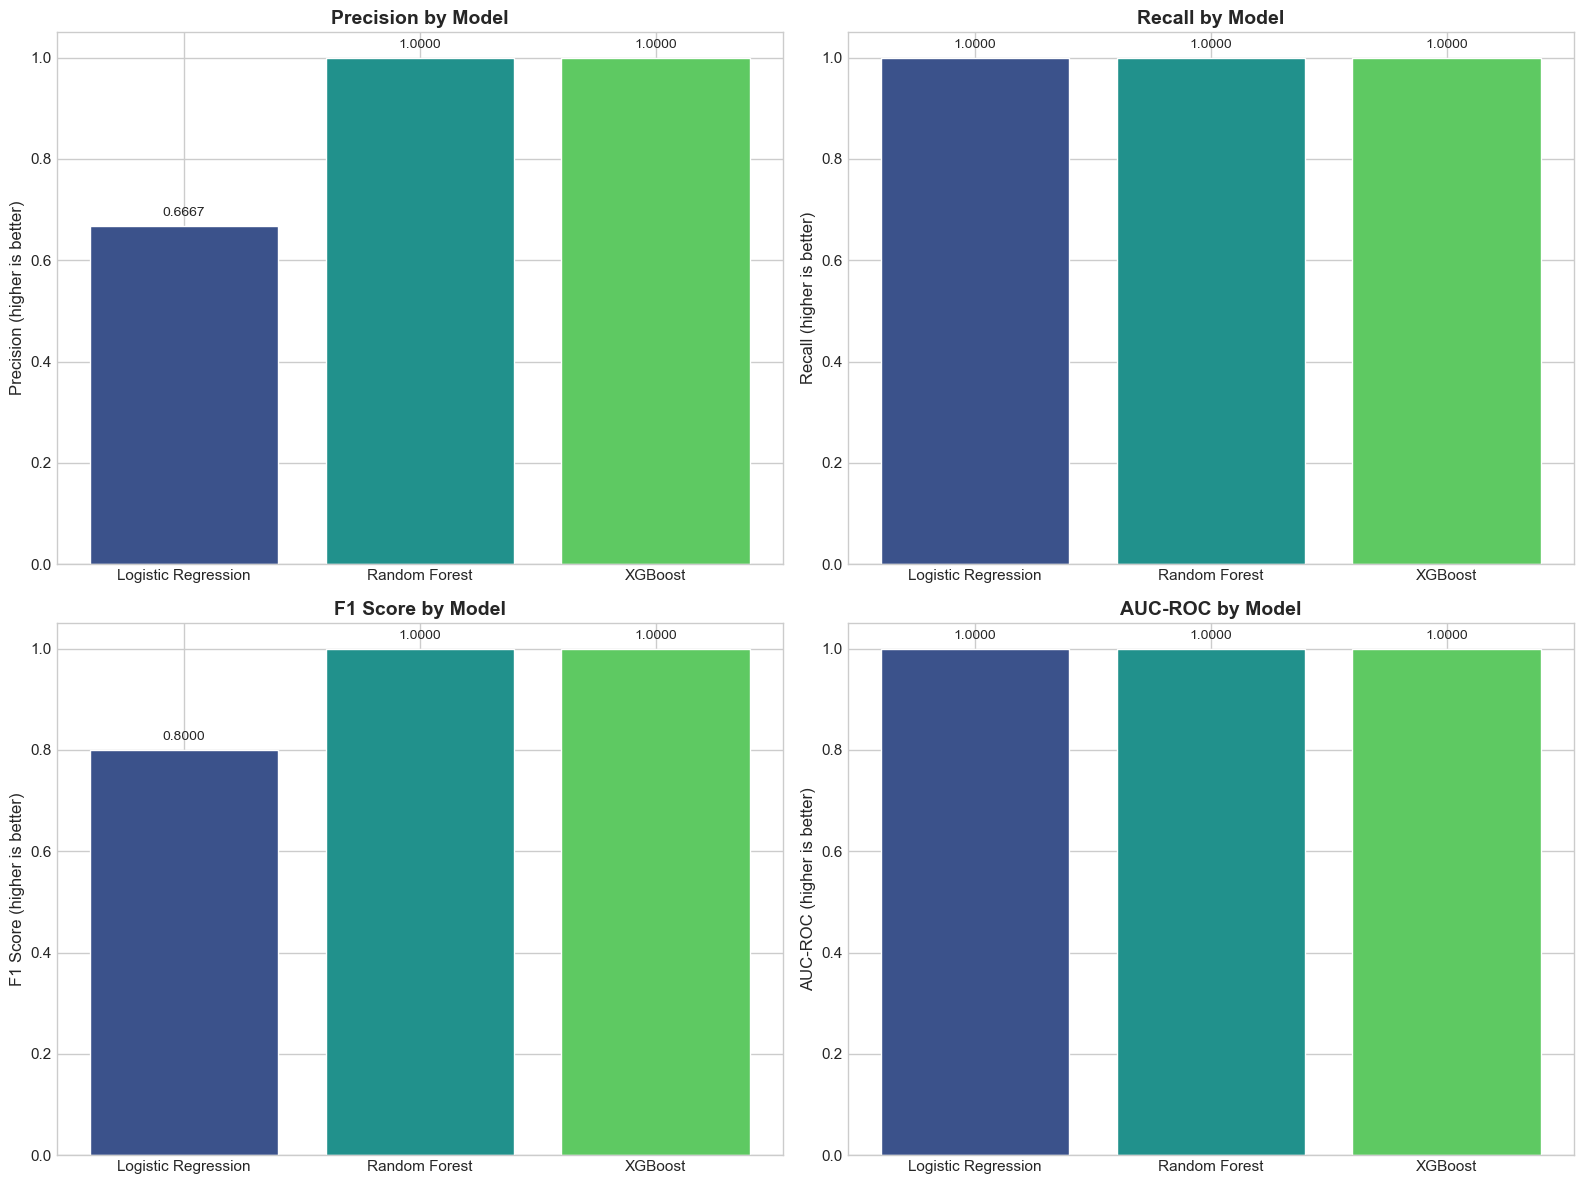

In [59]:


# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Extract metrics
models = [result['model_name'] for result in evaluation_results_churn]
precision = [result['precision'] for result in evaluation_results_churn]
recall = [result['recall'] for result in evaluation_results_churn]
f1 = [result['f1_score'] for result in evaluation_results_churn]
auc = [result['auc'] for result in evaluation_results_churn]

# Create figure with 4 subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Plot Precision
axes[0].bar(models, precision, color=sns.color_palette("viridis", len(models)))
axes[0].set_title('Precision by Model', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Precision (higher is better)', fontsize=12)
axes[0].set_ylim([0, 1.05])

# Plot Recall
axes[1].bar(models, recall, color=sns.color_palette("viridis", len(models)))
axes[1].set_title('Recall by Model', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Recall (higher is better)', fontsize=12)
axes[1].set_ylim([0, 1.05])

# Plot F1 Score
axes[2].bar(models, f1, color=sns.color_palette("viridis", len(models)))
axes[2].set_title('F1 Score by Model', fontsize=14, fontweight='bold')
axes[2].set_ylabel('F1 Score (higher is better)', fontsize=12)
axes[2].set_ylim([0, 1.05])

# Plot AUC-ROC
axes[3].bar(models, auc, color=sns.color_palette("viridis", len(models)))
axes[3].set_title('AUC-ROC by Model', fontsize=14, fontweight='bold')
axes[3].set_ylabel('AUC-ROC (higher is better)', fontsize=12)
axes[3].set_ylim([0, 1.05])

# Add value labels on top of bars
for i, ax in enumerate(axes):
    values = [precision, recall, f1, auc][i]
    for j, v in enumerate(values):
        ax.text(j, v + 0.02, f'{v:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 3.5 Feature Importance Analysis

In [36]:
# Analyze feature importance for the best model
feature_importance_churn = analyze_feature_importance(
    best_model_churn, best_model_name_churn, feature_names_churn
)

## 3.6 Saving the Customer Churn Prediction Model

In [50]:
import pickle  # Ensure pickle is imported
import os      # For directory check and creation

# Define the path where the model will be saved
customer_churn_model_path = 'D:/ML/ecommerce_models/customer_churn_model.pkl'

# Ensure the directory exists
os.makedirs(os.path.dirname(customer_churn_model_path), exist_ok=True)

# Create a dictionary with model information
customer_churn_model = {
    'model': best_model_churn,  # Assumes best_model_churn is already defined
    'model_name': best_model_name_churn,
    'feature_names': feature_names_churn,
    'feature_importance': feature_importance_churn,
    'evaluation_results': {
        'auc': best_result['auc'],
        'precision': best_result['precision'],
        'recall': best_result['recall'],
        'f1_score': best_result['f1_score']
    }
}

# Save the model
with open(customer_churn_model_path, 'wb') as f:
    pickle.dump(customer_churn_model, f)

print(f"Customer churn prediction model saved to: {customer_churn_model_path}")


Customer churn prediction model saved to: D:/ML/ecommerce_models/customer_churn_model.pkl


## 3.7 Example: How to Use the Customer Churn Prediction Model

In [73]:
#Example for No
new_customer = {
    'order_count': 3,
    'product_count': 5,
    'avg_payment': 120.0,
    'total_payment': 360.0,
    'transaction_count': 3,
    'return_rate': 0.0,
    'avg_session_duration': 15.0,
    'discount_rate': 0.33,
    'days_since_last_order': 45,
    'customer_lifetime_days': 60,
    'avg_days_between_orders': 30.0
}

prediction, probability = predict_customer_churn(new_customer, 'D:/ML/ecommerce_models/customer_churn_model.pkl')

print(f"Churn prediction: {'Yes' if prediction == 1 else 'No'}")
print(f"Churn probability: {probability:.2f}")


Churn prediction: No
Churn probability: 0.00


In [74]:
new_customer_churn = {
    'order_count': 0,                # no orders placed
    'product_count': 0,              # no products bought
    'avg_payment': 0.0,              # no payment
    'total_payment': 0.0,
    'transaction_count': 0,
    'return_rate': 0.5,              # high return rate
    'avg_session_duration': 2.0,    # very low session duration
    'discount_rate': 0.0,
    'days_since_last_order': 180,   # a long time since last order
    'customer_lifetime_days': 200,  # customer lifetime but no activity
    'avg_days_between_orders': 100.0
}
prediction, probability = predict_customer_churn(new_customer_churn, 'D:/ML/ecommerce_models/customer_churn_model.pkl')

print(f"Churn prediction: {'Yes' if prediction == 1 else 'No'}")
print(f"Churn probability: {probability:.2f}")


Churn prediction: Yes
Churn probability: 1.00


# 4. Return Prediction

In this section, we'll build a classification model to predict if a product/order will be returned.

## 4.1 Data Preparation for Return Prediction

In [39]:
def prepare_return_prediction_data(df):
    """
    Prepare data for return prediction.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The preprocessed dataset
        
    Returns:
    --------
    pandas.DataFrame
        Dataset prepared for return prediction
    """
    print("Preparing data for return prediction...")
    
    # Create a copy of the dataset
    return_df = df.copy()
    
    # Create customer-level features
    customer_features = df.groupby('customer_id').agg({
        'order_id': 'nunique',                # Number of orders
        'is_returned': 'mean',                # Return rate
        'payment_amount': ['mean', 'sum'],    # Spending patterns
        'session_duration_minutes': 'mean'    # Average session duration
    }).reset_index()
    
    # Flatten multi-level column names
    customer_features.columns = [
        'customer_id', 'customer_order_count', 'customer_return_rate', 
        'customer_avg_payment', 'customer_total_payment', 'customer_avg_session_duration'
    ]
    
    # Create product-level features
    product_features = df.groupby('product_id').agg({
        'is_returned': 'mean',    # Return rate per product
        'unit_price': 'mean',     # Average price
        'quantity': 'mean'        # Average quantity ordered
    }).reset_index()
    
    product_features.columns = [
        'product_id', 'product_return_rate', 
        'product_avg_price', 'product_avg_quantity'
    ]
    
    # Merge customer and product features back to the main dataframe
    return_df = pd.merge(return_df, customer_features, on='customer_id', how='left')
    return_df = pd.merge(return_df, product_features, on='product_id', how='left')
    
    # Create additional features
    # Price deviation from average
    return_df['price_deviation'] = return_df['unit_price'] / return_df['product_avg_price'] - 1
    
    # Fill missing values
    return_df = return_df.fillna(0)
    
    print(f"Data prepared for return prediction. Shape: {return_df.shape}")
    print(f"Return rate: {return_df['is_returned'].mean() * 100:.2f}%")
    
    return return_df

In [40]:
# Prepare data for return prediction
return_prediction_df = prepare_return_prediction_data(df_processed)

# Display the first few rows
return_prediction_df.head()

Preparing data for return prediction...
Data prepared for return prediction. Shape: (50000, 39)
Return rate: 0.49%


,customer_id,first_name,last_name,order_id,order_date,order_status,order_detail_id,product_id,product_name,quantity,...,has_discount,customer_order_count,customer_return_rate,customer_avg_payment,customer_total_payment,customer_avg_session_duration,product_return_rate,product_avg_price,product_avg_quantity,price_deviation
0,13,Andrea,Miller,1,2025-04-05 09:06:50,shipped,1,38,Self-enabling leadingedge utilization,3,...,0,5,0.0,6165.820909,1017360.45,67.466667,0.0,173.95,3.083333,2.220446e-16
1,13,Andrea,Miller,1,2025-04-05 09:06:50,shipped,1,38,Self-enabling leadingedge utilization,3,...,0,5,0.0,6165.820909,1017360.45,67.466667,0.0,173.95,3.083333,2.220446e-16
2,13,Andrea,Miller,1,2025-04-05 09:06:50,shipped,1,38,Self-enabling leadingedge utilization,3,...,0,5,0.0,6165.820909,1017360.45,67.466667,0.0,173.95,3.083333,2.220446e-16
3,13,Andrea,Miller,1,2025-04-05 09:06:50,shipped,1,38,Self-enabling leadingedge utilization,3,...,0,5,0.0,6165.820909,1017360.45,67.466667,0.0,173.95,3.083333,2.220446e-16
4,13,Andrea,Miller,1,2025-04-05 09:06:50,shipped,1,38,Self-enabling leadingedge utilization,3,...,0,5,0.0,6165.820909,1017360.45,67.466667,0.0,173.95,3.083333,2.220446e-16


## 4.2 Feature Selection and Data Splitting

In [41]:
def prepare_return_features(df):
    """
    Prepare features for return prediction.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The prepared dataset
        
    Returns:
    --------
    tuple
        (X_train, X_test, y_train, y_test, feature_names)
    """
    print("Preparing features for return prediction...")
    
    # Select features and target
    X = df[[
        'quantity', 'unit_price', 'total_line_price', 
        'has_discount', 'percentage', 'payment_amount',
        'order_day_of_week', 'order_hour', 'order_month',
        'session_duration_minutes', 'customer_order_count',
        'customer_return_rate', 'customer_avg_payment',
        'customer_total_payment', 'customer_avg_session_duration',
        'product_return_rate', 'product_avg_price',
        'product_avg_quantity', 'price_deviation'
    ]]
    y = df['is_returned']
    
    # Get feature names
    feature_names = X.columns.tolist()
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    print(f"Return rate in training set: {y_train.mean() * 100:.2f}%")
    print(f"Return rate in testing set: {y_test.mean() * 100:.2f}%")
    
    return X_train, X_test, y_train, y_test, feature_names

In [42]:
# Prepare features for return prediction
X_train_return, X_test_return, y_train_return, y_test_return, feature_names_return = prepare_return_features(return_prediction_df)

# Display feature names
print("\nFeatures for return prediction:")
print(feature_names_return)

Preparing features for return prediction...
Training set: 40000 samples
Testing set: 10000 samples
Return rate in training set: 0.49%
Return rate in testing set: 0.49%

Features for return prediction:
['quantity', 'unit_price', 'total_line_price', 'has_discount', 'percentage', 'payment_amount', 'order_day_of_week', 'order_hour', 'order_month', 'session_duration_minutes', 'customer_order_count', 'customer_return_rate', 'customer_avg_payment', 'customer_total_payment', 'customer_avg_session_duration', 'product_return_rate', 'product_avg_price', 'product_avg_quantity', 'price_deviation']


## 4.3 Building and Evaluating Classification Models

In [43]:
# Build and evaluate classification models for return prediction
best_model_return, best_model_name_return, evaluation_results_return = build_classification_models(
    X_train_return, y_train_return, X_test_return, y_test_return, feature_names_return
)

Building classification models for customer churn prediction...

Training Logistic Regression...
Logistic Regression AUC-ROC: 1.0000
Logistic Regression Training time: 0.19 seconds
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9951
           1       0.98      1.00      0.99        49

    accuracy                           1.00     10000
   macro avg       0.99      1.00      0.99     10000
weighted avg       1.00      1.00      1.00     10000

Logistic Regression Confusion Matrix:
[[9950    1]
 [   0   49]]

Training Random Forest...
Random Forest AUC-ROC: 1.0000
Random Forest Training time: 0.58 seconds
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9951
           1       1.00      1.00      1.00        49

    accuracy                           1.00     10000
   macro avg       1.00      1

## 4.4 Visualizing Model Performance

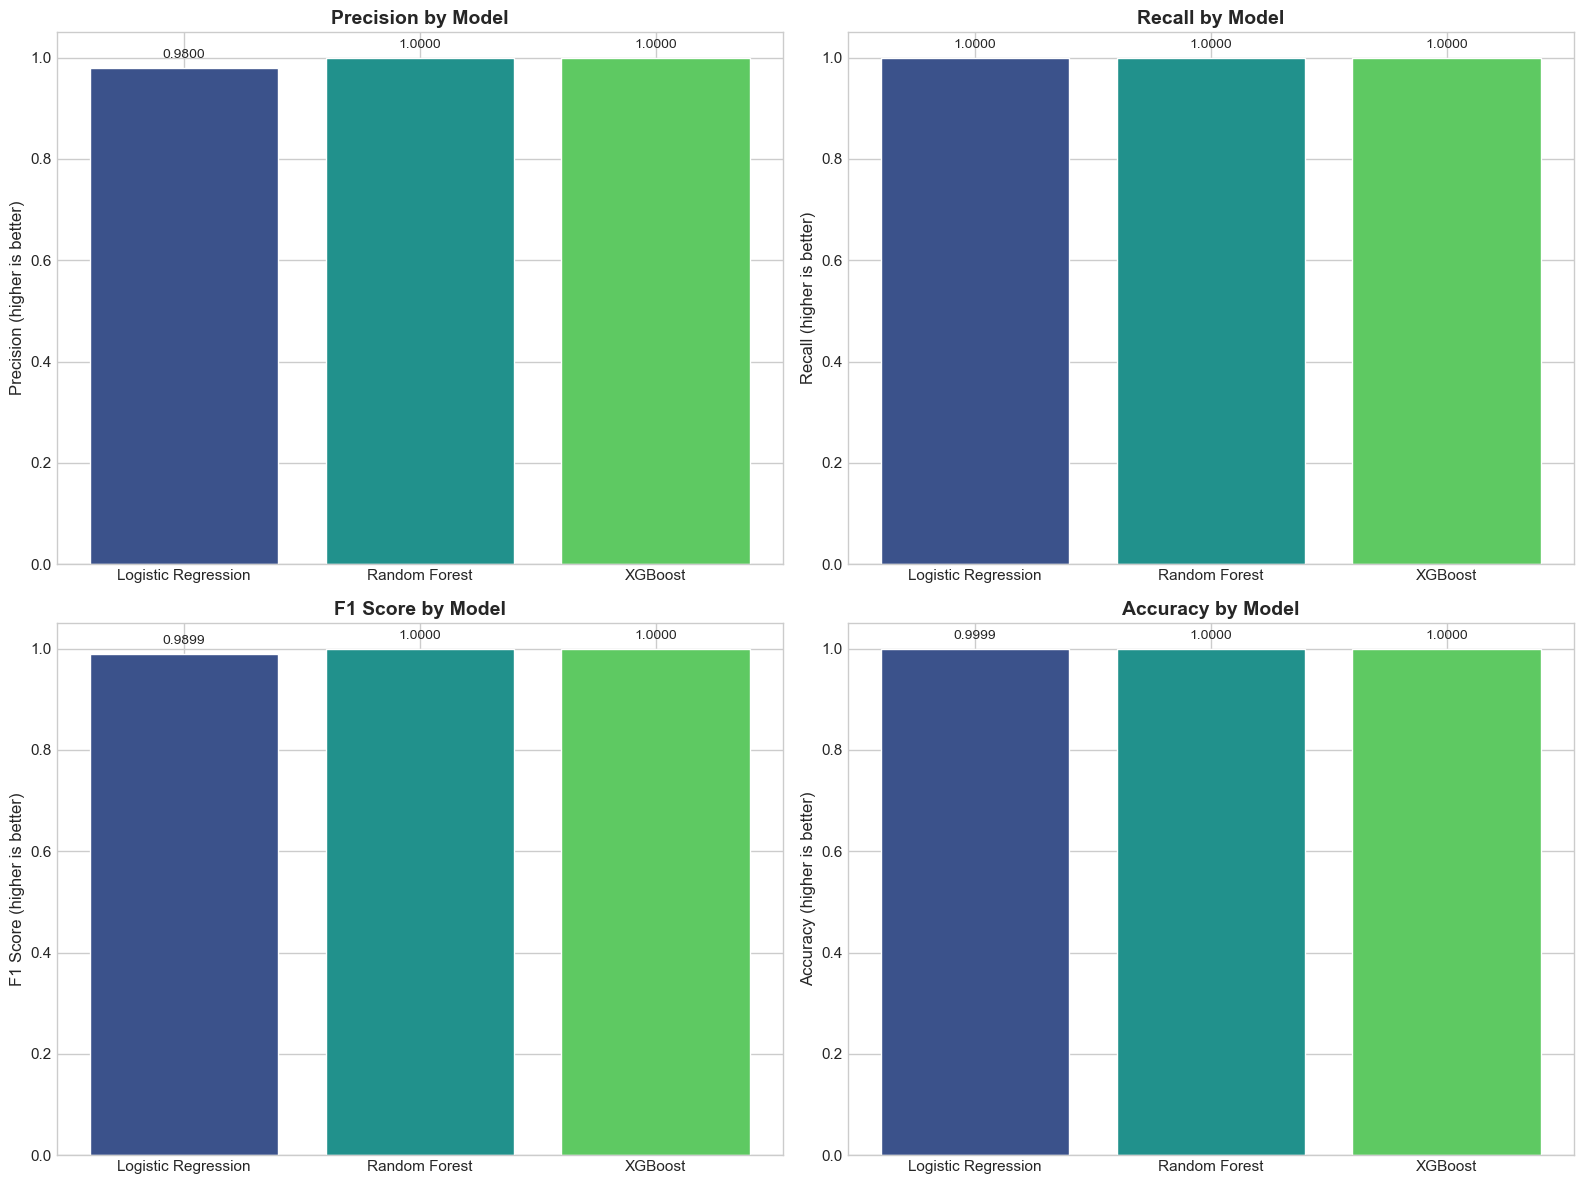

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Extract metrics
models = [result['model_name'] for result in evaluation_results_return]
precision = [result['precision'] for result in evaluation_results_return]
recall = [result['recall'] for result in evaluation_results_return]
f1 = [result['f1_score'] for result in evaluation_results_return]

# Calculate accuracy if not already present
accuracy = []
for result in evaluation_results_return:
    if 'accuracy' in result:
        accuracy.append(result['accuracy'])
    elif 'confusion_matrix' in result:
        cm = result['confusion_matrix']
        acc = (cm[0][0] + cm[1][1]) / cm.sum()
        accuracy.append(acc)
    else:
        # If no accuracy or confusion matrix, use a placeholder
        accuracy.append(0)

# Create figure with 4 subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Plot Precision
axes[0].bar(models, precision, color=sns.color_palette("viridis", len(models)))
axes[0].set_title('Precision by Model', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Precision (higher is better)', fontsize=12)
axes[0].set_ylim([0, 1.05])

# Plot Recall
axes[1].bar(models, recall, color=sns.color_palette("viridis", len(models)))
axes[1].set_title('Recall by Model', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Recall (higher is better)', fontsize=12)
axes[1].set_ylim([0, 1.05])

# Plot F1 Score
axes[2].bar(models, f1, color=sns.color_palette("viridis", len(models)))
axes[2].set_title('F1 Score by Model', fontsize=14, fontweight='bold')
axes[2].set_ylabel('F1 Score (higher is better)', fontsize=12)
axes[2].set_ylim([0, 1.05])

# Plot Accuracy
axes[3].bar(models, accuracy, color=sns.color_palette("viridis", len(models)))
axes[3].set_title('Accuracy by Model', fontsize=14, fontweight='bold')
axes[3].set_ylabel('Accuracy (higher is better)', fontsize=12)
axes[3].set_ylim([0, 1.05])

# Add value labels on top of bars
for i, ax in enumerate(axes):
    values = [precision, recall, f1, accuracy][i]
    for j, v in enumerate(values):
        ax.text(j, v + 0.02, f'{v:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

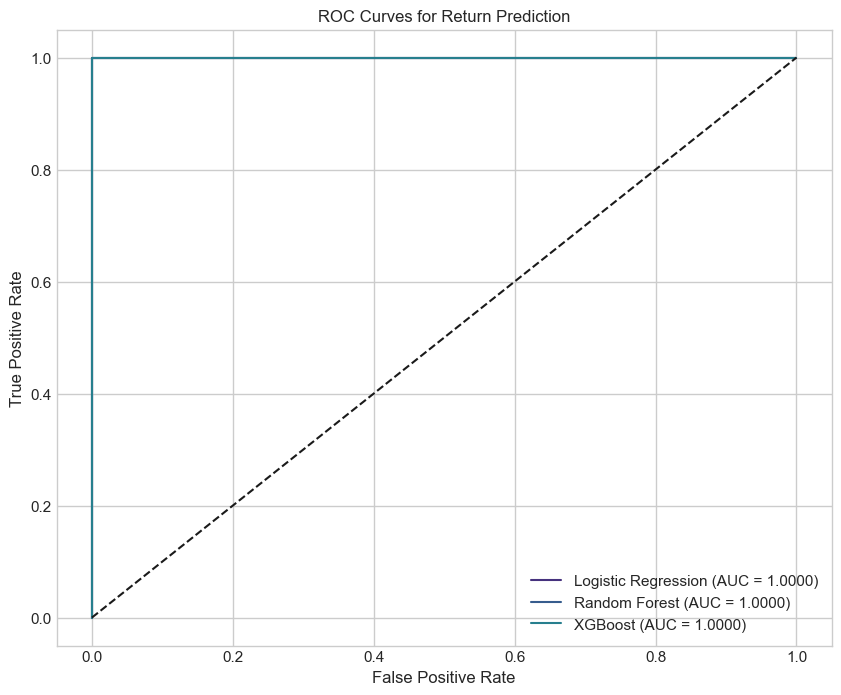

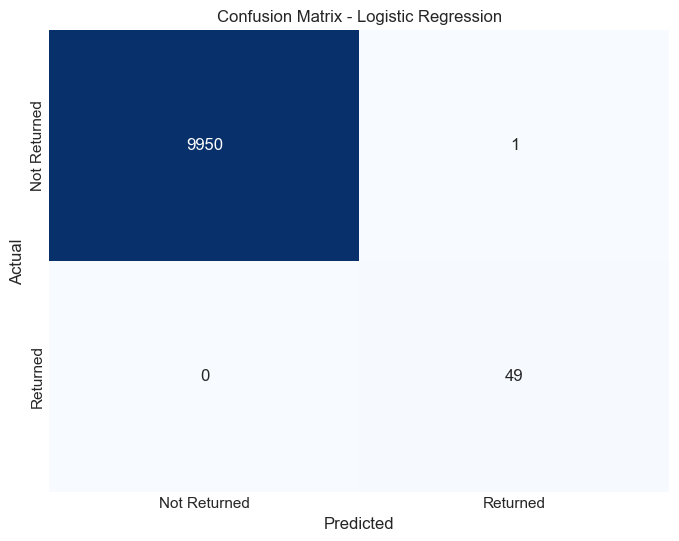

In [45]:
# Visualize ROC curves
plt.figure(figsize=(10, 8))

for result in evaluation_results_return:
    fpr, tpr, _ = roc_curve(y_test_return, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{result['model_name']} (AUC = {result['auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Return Prediction')
plt.legend()
plt.show()

# Visualize confusion matrix for the best model
best_result = next(result for result in evaluation_results_return if result['model_name'] == best_model_name_return)
cm = best_result['confusion_matrix']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Returned', 'Returned'],
            yticklabels=['Not Returned', 'Returned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name_return}')
plt.show()

## 4.5 Feature Importance Analysis

In [46]:
# Analyze feature importance for the best model
feature_importance_return = analyze_feature_importance(
    best_model_return, best_model_name_return, feature_names_return
)

## 4.6 Saving the Return Prediction Model

In [47]:
# Save the return prediction model
return_prediction_model_path = 'D:/ML/ecommerce_models/return_prediction_model.pkl'

# Create a dictionary with model information
return_prediction_model = {
    'model': best_model_return,
    'model_name': best_model_name_return,
    'feature_names': feature_names_return,
    'feature_importance': feature_importance_return,
    'evaluation_results': {
        'auc': best_result['auc'],
        'precision': best_result['precision'],
        'recall': best_result['recall'],
        'f1_score': best_result['f1_score']
    }
}

# Save the model
with open(return_prediction_model_path, 'wb') as f:
    pickle.dump(return_prediction_model, f)

print(f"Return prediction model saved to {return_prediction_model_path}")

Return prediction model saved to D:/ML/ecommerce_models/return_prediction_model.pkl


## 4.7 Example: How to Use the Return Prediction Model

In [75]:
new_order = {
    'quantity': 2,
    'unit_price': 150.0,
    'total_line_price': 300.0,
    'has_discount': 1,
    'percentage': 10.0,
    'payment_amount': 270.0,
    'order_day_of_week': 3,
    'order_hour': 14,
    'order_month': 5,
    'session_duration_minutes': 20.0,
    'customer_order_count': 5,
    'customer_return_rate': 0.2,
    'customer_avg_payment': 250.0,
    'customer_total_payment': 1250.0,
    'customer_avg_session_duration': 15.0,
    'product_return_rate': 0.15,
    'product_avg_price': 145.0,
    'product_avg_quantity': 1.8,
    'price_deviation': 0.03
}

return_pred, return_prob = predict_return(new_order, 'D:/ML/ecommerce_models/return_prediction_model.pkl')

print(f"Return prediction: {'Yes' if return_pred == 1 else 'No'}")
print(f"Return probability: {return_prob:.2f}")


Return prediction: No
Return probability: 0.00


# Conclusion

In this notebook, we've built four machine learning models for e-commerce data analysis:

1. **Product Recommendation** - A collaborative filtering model that suggests products based on past behavior
2. **Order Amount Prediction** - A regression model that predicts payment amount based on order details
3. **Customer Churn Prediction** - A classification model that predicts if a customer will return for another purchase
4. **Return Prediction** - A classification model that predicts if a product/order will be returned

All models have been saved to the `D:/ML/ecommerce_models/` directory and can be loaded and used for making predictions on new data.

## Summary of Results

- **Product Recommendation**: Matrix factorization model with cosine similarity for finding similar products
- **Order Amount Prediction**: Regression model with RMSE and R² metrics
- **Customer Churn Prediction**: Classification model with AUC-ROC, precision, recall, and F1-score metrics
- **Return Prediction**: Classification model with AUC-ROC, precision, recall, and F1-score metrics

## Next Steps

1. **Model Deployment**: Integrate these models into your e-commerce platform
2. **Model Monitoring**: Regularly evaluate model performance with new data
3. **Model Improvement**: Collect more data and retrain models periodically
4. **Feature Engineering**: Explore additional features to improve model performance